<a href="https://colab.research.google.com/github/HanaTounakti/Food-sales-predictions/blob/main/Hana_Tounakti__Belt_ExamA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import nltk

import tensorflow as tf
import numpy as np
import seaborn as sns

## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.models import Sequential
from sklearn.naive_bayes import MultinomialNB
# Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [85]:
def preprocess_text(txt, nlp=None, remove_stopwords=True, remove_punct=True, use_lemmas=False):
    """Preprocess text into tokens/lemmas.
    Args:
        txt (string): text to process
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None
                                      if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
    Returns:
        list: list of tokens/lemmas
    """
    if nlp is None:
        nlp = spacy.load('en_core_web_sm')
    doc = nlp(txt)
    # Saving list of the token objects for stopwords and punctuation removal
    tokens = []
    for token in doc:
        # Check if should remove stopwords and if token is stopword
        if (remove_stopwords == True) & (token.is_stop == True):
            # Continue the loop with the next token
            continue
        # Check if should remove punctuation and if token is punctuation
        if (remove_punct == True) & (token.is_punct == True):
            # Continue the loop with the next oken
            continue
        # Check if should remove punctation and if token is space
        if (remove_punct == True) & (token.is_space == True):
            continue
        # Determine final form of output list of tokens/lemmas
        if use_lemmas:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text.lower())
    return tokens

In [86]:
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import spacy


# Function to preprocess the texts
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts


def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder

    elif ngrams == 3:
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()


    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



def build_gru_model(text_vectorization_layer):


    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    gru_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM,
                                  input_length=SEQUENCE_LENGTH)
        ])

    # Add GRU layer
    gru_model.add(layers.LSTM(128))

    # Add output layer
    gru_model.add(layers.Dense(len(classes), activation='softmax'))

    # Compile the model
    gru_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    gru_model.summary()
    return gru_model

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()


def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

#Part 1: NLP

Preprocessing

1-Load in the text classification dataframe from the provided file (part1-aml-belt-exam.csv)

2-Load the en_core_web_sm version of the spacy pipeline with the parser and ner disabled.

3-Preprocess with spacy:

Create a column with Tokenized text (no stopwords)

Create a column with Lemmatized text (no stopwords)

Create a column with the tokens for each text joined together as a single string.

Create a column with the lemmas for each text joined together as a single string.*texte en italique*

In [87]:
#1-Load in the text classification dataframe from the provided file (part1-aml-belt-exam.csv)
df = pd.read_csv('/content/part1-aml-belt-exam.csv')
df.head()

,author,text
0,Poe,additional information either on Monday ...
1,Poe,teeth. Not a speck on their surface—not ...
2,Dickens,“Harry? As soon as he had seen your friend her...
3,Poe,thought—to make sure that my vision had ...
4,Poe,the flowers. No guile disguised the ferv...


In [88]:
#2-Load the en_core_web_sm version of the spacy pipeline with the parser and ner disabled.
nlp_lite = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp_lite

In [89]:
#3-Preprocess with spacy:
df['tokens']= batch_preprocess_texts(df['text'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = False,)

0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
3551it [00:29, 120.90it/s]


In [90]:
df['lemmas']= batch_preprocess_texts(df['text'],nlp=nlp_lite, remove_stopwords = True, remove_punct =True, use_lemmas = True,)

0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
3551it [00:27, 128.55it/s]


In [91]:
df.head()

,author,text,tokens,lemmas
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]"
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]"
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]"
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]"
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]"


In [92]:
df['joined_tokens'] = df['tokens'].map(lambda x: " ".join(x))
df['joined_tokens']

,joined_tokens
0,additional information monday course
1,teeth speck surface shade
2,harry soon seen friend safe coach
3,thought sure vision deceived calm
4,flowers guile disguised fervor love animated
...,...
3546,condition shadow doubt appertaining present
3547,left vanities turbulent triumphs
3548,soul intense painful meditation roaming
3549,scenes past resolved amend new sphere


In [93]:
df['joined_lemmas'] = df['lemmas'].map(lambda x: " ".join(x))
df['joined_lemmas']

,joined_lemmas
0,additional information monday course
1,tooth speck surface shade
2,harry soon see friend safe coach
3,think sure vision deceive calm
4,flower guile disguise fervor love animate
...,...
3546,condition shadow doubt appertain present
3547,leave vanity turbulent triumph
3548,soul intense painful meditation roam
3549,scene past resolve amend new sphere


Perform group comparison EDA:

1-Define/separate two groups based on the author of the text (Poe or Dickens)

2-Create word clouds for each group using raw text.

3-Create word clouds for each group using the joined lemmatized text.

4-Display the top 20 most frequent bigrams of tokens (use the .raw_freq score) for both groups in a single dataframe

In [94]:
df['author'].value_counts()

,count
author,
Poe,2075
Dickens,1476


In [95]:
grp_Poe = df.loc[df['author'] == 'Poe']

In [96]:
grp_Poe.head()

,author,text,tokens,lemmas,joined_tokens,joined_lemmas
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]",thought sure vision deceived calm,think sure vision deceive calm
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]",flowers guile disguised fervor love animated,flower guile disguise fervor love animate
5,Poe,came and went!—and the victim—where is s...,"[came, went!—and, victim, knew]","[come, went!—and, victim, know]",came went!—and victim knew,come went!—and victim know


In [97]:
grp_Dickens = df.loc[df['author'] == 'Dickens']
grp_Dickens.head()

,author,text,tokens,lemmas,joined_tokens,joined_lemmas
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach
9,Dickens,Perfect stillness ensued—not a rustle—not a br...,"[perfect, stillness, ensued, rustle, breath, g...","[perfect, stillness, ensue, rustle, breath, gu...",perfect stillness ensued rustle breath guilty,perfect stillness ensue rustle breath guilty
11,Dickens,birth and parentage. Those proofs were destroy...,"[birth, parentage, proofs, destroyed]","[birth, parentage, proof, destroy]",birth parentage proofs destroyed,birth parentage proof destroy
14,Dickens,"collect his thoughts. After awhile, he began t...","[collect, thoughts, awhile, began, remember]","[collect, thought, awhile, begin, remember]",collect thoughts awhile began remember,collect thought awhile begin remember
15,Dickens,"Roused into new strength and energy, and stimu...","[roused, new, strength, energy, stimulated, no...","[rouse, new, strength, energy, stimulate, noise]",roused new strength energy stimulated noise,rouse new strength energy stimulate noise


In [98]:
# get the text for group Poe and display

grp_Poe_text = " ".join(grp_Poe['text'])
print(grp_Poe_text[:500],"\n")

      additional information either on Monday or in the course of the       teeth. Not a speck on their surface—not a shade on their       thought—to make sure that my vision had not deceived me—to calm       the flowers. No guile disguised the fervor of love which animated       came and went!—and the victim—where is she? I knew her not—or       was not visited upon me. And once—but once again in the silence       Yet let me not be misapprehended. The undue, earnest, and morbid       lofty, as  



In [99]:
# get the text for group Dickens and display

grp_Dickens_text = " ".join(grp_Dickens['text'])
print(grp_Dickens_text[:500],"\n")

“Harry? As soon as he had seen your friend here, safe in a coach with Perfect stillness ensued—not a rustle—not a breath—Guilty. birth and parentage. Those proofs were destroyed by you, and now, in collect his thoughts. After awhile, he began to remember a few Roused into new strength and energy, and stimulated by the noise within these dogs?” asked Monks, looking from one to the other of the men who disgrace on no one living, except you who use it. Let that pass. He was The knocking came again. 



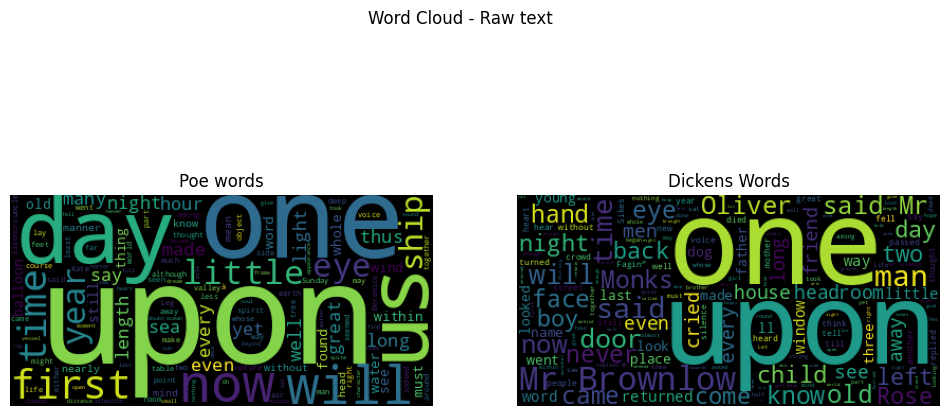

In [100]:
# Create a word clouds of above texts

from wordcloud import WordCloud, STOPWORDS
Poe_cloud = WordCloud(min_word_length=2).generate(grp_Poe_text)
Dickens_cloud = WordCloud(min_word_length=2).generate(grp_Dickens_text)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(Poe_cloud)
axes[0].set_title('Poe words')
axes[0].axis('off')

axes[1].imshow(Dickens_cloud)
axes[1].set_title('Dickens Words')
axes[1].axis('off');
fig.suptitle('Word Cloud - Raw text');

In [101]:
# get the text for group Poe and display

grp_Poe_text = " ".join(grp_Poe['joined_lemmas'])
print(grp_Poe_text[:500],"\n")

# get the text for group Dickens and display

grp_Dickens_text = " ".join(grp_Dickens['joined_lemmas'])
print(grp_Dickens_text[:500],"\n")

additional information monday course tooth speck surface shade think sure vision deceive calm flower guile disguise fervor love animate come went!—and victim know visit silence let misapprehend undue earnest morbid lofty appearance bonnet crown flesh 18 earth uphold cow blue color have horn gallon black strap have imbibe prosperity mental life hold light turn northward sun arise sickly yellow lustre replete horror horror horrible vague ship grow bulk like live body thing reason bear resemblance  

harry soon see friend safe coach perfect stillness ensue rustle breath guilty birth parentage proof destroy collect thought awhile begin remember rouse new strength energy stimulate noise dog ask monks look man disgrace live use let pass knocking come knock like hand head half brother illegitimate son centre crowd street corner swear old officer know grow love clothe teach send quiet country place grief mingle cup bitter tear wot come young bate demand kags bald name boy grey listen room smal

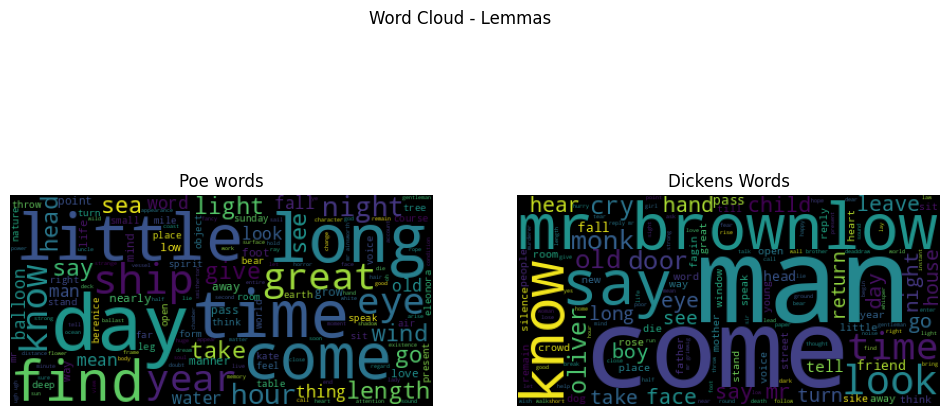

In [102]:
# Create a word clouds of above texts

from wordcloud import WordCloud, STOPWORDS
Poe_cloud = WordCloud(min_word_length=2).generate(grp_Poe_text)
Dickens_cloud = WordCloud(min_word_length=2).generate(grp_Dickens_text)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(Poe_cloud)
axes[0].set_title('Poe words')
axes[0].axis('off')

axes[1].imshow(Dickens_cloud)
axes[1].set_title('Dickens Words')
axes[1].axis('off')
fig.suptitle('Word Cloud - Lemmas');

In [103]:
#Display the top 20 most frequent bigrams of tokens

In [104]:
grp_Poe_tokens = grp_Poe['tokens'].explode().astype(str).to_list()

In [105]:
grp_Dickens_tokens = grp_Dickens['tokens'].explode().astype(str).to_list()

In [106]:
grp_Poe_tokens

['additional',
 'information',
 'monday',
 'course',
 'teeth',
 'speck',
 'surface',
 'shade',
 'thought',
 'sure',
 'vision',
 'deceived',
 'calm',
 'flowers',
 'guile',
 'disguised',
 'fervor',
 'love',
 'animated',
 'came',
 'went!—and',
 'victim',
 'knew',
 'visited',
 'silence',
 'let',
 'misapprehended',
 'undue',
 'earnest',
 'morbid',
 'lofty',
 'appearance',
 'bonnet',
 'crown',
 'flesh',
 '18',
 'earth',
 'upheld',
 'cow',
 'blue',
 'color',
 'having',
 'horns',
 'gallon',
 'black',
 'strap',
 'having',
 'imbibed',
 'prosperity',
 'mental',
 'life',
 'held',
 'light',
 'turned',
 'northward',
 'sun',
 'arose',
 'sickly',
 'yellow',
 'lustre',
 'replete',
 'horror',
 'horror',
 'horrible',
 'vague',
 'ship',
 'grow',
 'bulk',
 'like',
 'living',
 'body',
 'things',
 'reason',
 'bore',
 'resemblance',
 'ocean',
 'crag',
 'spoken',
 'bid',
 'good',
 'bye',
 'way',
 'like',
 'tons',
 'whirled',
 'paddington',
 'didcot',
 '53',
 'miles',
 '51',
 'wind',
 'set',
 'motion',
 'spring

In [107]:
grp_Dickens_tokens

['harry',
 'soon',
 'seen',
 'friend',
 'safe',
 'coach',
 'perfect',
 'stillness',
 'ensued',
 'rustle',
 'breath',
 'guilty',
 'birth',
 'parentage',
 'proofs',
 'destroyed',
 'collect',
 'thoughts',
 'awhile',
 'began',
 'remember',
 'roused',
 'new',
 'strength',
 'energy',
 'stimulated',
 'noise',
 'dogs',
 'asked',
 'monks',
 'looking',
 'men',
 'disgrace',
 'living',
 'use',
 'let',
 'pass',
 'knocking',
 'came',
 'knocked',
 'like',
 'hand',
 'head',
 'half',
 'brother',
 'illegitimate',
 'son',
 'centre',
 'crowd',
 'street',
 'corner',
 'swore',
 'old',
 'officer',
 'knew',
 'grew',
 'love',
 'clothed',
 'taught',
 'send',
 'quiet',
 'country',
 'place',
 'grief',
 'mingled',
 'cup',
 'bitter',
 'tears',
 'wot',
 'come',
 'young',
 'bates',
 'demanded',
 'kags',
 'bald',
 'named',
 'boy',
 'grey',
 'listened',
 'rooms',
 'small',
 'filthy',
 'confined',
 'air',
 'torture',
 'protracted',
 'anguish',
 'ill',
 'assorted',
 'union',
 'know',
 'said',
 'young',
 'man',
 'detainin

In [108]:
# using custom function get_ngram_measures_finder to get the bigrams

bigram_grp_Poe = get_ngram_measures_finder(grp_Poe_tokens,top_n=20)

bigram_grp_Dickens = get_ngram_measures_finder(grp_Dickens_tokens,top_n=20)

In [109]:
bigram_grp_Poe,bigram_grp_Dickens

(                  Words  Raw Freq
 0      (mr., ainsworth)  0.000939
 1     (thousand, miles)  0.000835
 2         (guide, rope)  0.000730
 3     (valley, colored)  0.000730
 4      (colored, grass)  0.000626
 5      (captain, pratt)  0.000522
 6          (dubble, l.)  0.000522
 7          (king, pest)  0.000522
 8             (l., dee)  0.000522
 9     (mr., rumgudgeon)  0.000522
 10       (25,000, feet)  0.000417
 11     (doctor, dubble)  0.000417
 12             (ha, ha)  0.000417
 13       (mr., osborne)  0.000417
 14     (studding, sail)  0.000417
 15  (uncle, rumgudgeon)  0.000417
 16  (yesterday, sunday)  0.000417
 17        (1000, years)  0.000313
 18           (20, 1000)  0.000313
 19          (ana, pest)  0.000313,
                Words  Raw Freq
 0    (mr., brownlow)  0.008480
 1        (said, mr.)  0.004924
 2     (mr., grimwig)  0.001915
 3     (replied, mr.)  0.001778
 4      (mr., bumble)  0.001231
 5      (said, monks)  0.001094
 6     (mrs., maylie)  0.000957
 7   (ol

#Text Classification - Machine Learning


Build, fit, and evaluate a binary MultinomialNB classifier to predict the author from the original raw text.

Do not remove stopwords

Use a random state of 321 for your train test split

No need to balance the dataset

Use a pipeline to include the count vectorizer and classification model

You do not need to tune the model

Save your model pipeline to a Models folder in your repo as a joblib file.

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3551 entries, 0 to 3550
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         3551 non-null   object
 1   text           3551 non-null   object
 2   tokens         3551 non-null   object
 3   lemmas         3551 non-null   object
 4   joined_tokens  3551 non-null   object
 5   joined_lemmas  3551 non-null   object
dtypes: object(6)
memory usage: 166.6+ KB


In [111]:
# define X and y

X = df['text']
y = df['author']

In [112]:
# No need to balance the dataset though lets check the balance for information

y.value_counts()

,count
author,
Poe,2075
Dickens,1476


In [113]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=321)

In [114]:
# Modeling

# using raw text (text) , creating pipeline with count vectorizer and classification model

## Create a model pipeline for inference.
nb_clf = MultinomialNB()

nb_pipe = Pipeline([('countvectorizer', CountVectorizer()),
                       ('nb_classifier', nb_clf)])

#nb_pipe.fit(X_train, y_train)

In [115]:
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('nb_classifier', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       0.94      0.97      0.96      1132
         Poe       0.98      0.95      0.97      1531

    accuracy                           0.96      2663
   macro avg       0.96      0.96      0.96      2663
weighted avg       0.96      0.96      0.96      2663



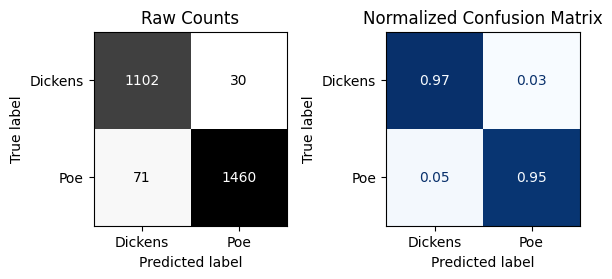


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       0.78      0.85      0.82       344
         Poe       0.90      0.85      0.88       544

    accuracy                           0.85       888
   macro avg       0.84      0.85      0.85       888
weighted avg       0.85      0.85      0.85       888



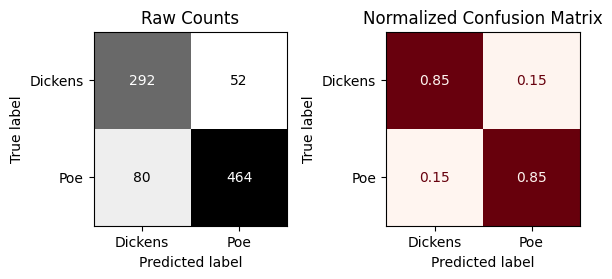

In [116]:
# using custom classification evaluation function to evaluate

evaluate_classification(nb_pipe, X_train, y_train, X_test, y_test)

In [117]:
# Save your model pipeline to a Models folder in your repo as a joblib file.

In [118]:
import os

os.makedirs('Models/' ,exist_ok =True)

In [119]:
import joblib
fpath_model = "Models/nb_classifierexam.joblib"
joblib.dump(nb_pipe, fpath_model)

['Models/nb_classifierexam.joblib']

#Text Classification - Deep NLP

Prepare tensorflow datasets for a train/val/test split.

No need to balance classes

Note: Make sure your target is encoded numerically (integers).

Use a batch size of 32.

In [120]:
# Make sure your target is encoded numerically (integers)
# Use labelencoder to encode the target

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([1, 1, 0, ..., 1, 0, 0])

In [121]:
# Use a batch size of 32
BATCH_SIZE =32

In [122]:
df['text']

,text
0,additional information either on Monday ...
1,teeth. Not a speck on their surface—not ...
2,“Harry? As soon as he had seen your friend her...
3,thought—to make sure that my vision had ...
4,the flowers. No guile disguised the ferv...
...,...
3546,"condition of shadow and doubt, appertain..."
3547,I left it for ever for the vanities and ...
3548,"soul, to the most intense and painful me..."
3549,"upon the scenes of the past, resolved to amend..."


In [123]:
# Add a column to the dataframe that has the length of each paragraph
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,author,text,tokens,lemmas,joined_tokens,joined_lemmas,sequence_length
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course,17
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade,17
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach,15
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]",thought sure vision deceived calm,think sure vision deceive calm,17
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]",flowers guile disguised fervor love animated,flower guile disguise fervor love animate,17


In [124]:
df['sequence_length'].describe()

,sequence_length
count,3551.000000
mean,14.643199
std,3.129817
min,6.000000
25%,12.000000
50%,15.000000
75%,17.000000
max,22.000000


In [125]:
#the max sequence length is 22 let's take 22 as seq legnth
SEQUENCE_LENGTH = 22

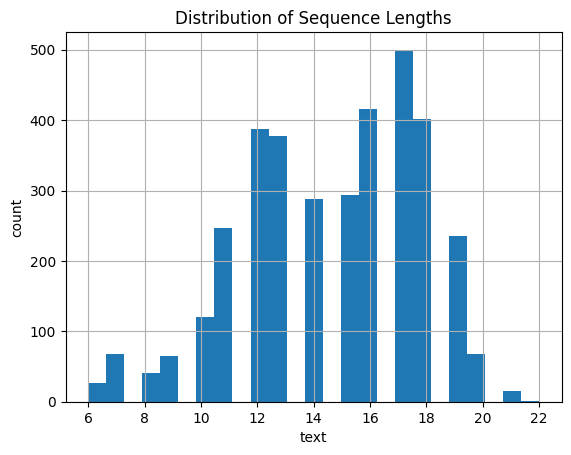

In [126]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('text')
ax.set_ylabel('count')
ax.set_title('Distribution of Sequence Lengths');

In [127]:
#prepare the dataset for modeling

print(X)

0             additional information either on Monday ...
1             teeth. Not a speck on their surface—not ...
2       “Harry? As soon as he had seen your friend her...
3             thought—to make sure that my vision had ...
4             the flowers. No guile disguised the ferv...
                              ...                        
3546          condition of shadow and doubt, appertain...
3547          I left it for ever for the vanities and ...
3548          soul, to the most intense and painful me...
3549    upon the scenes of the past, resolved to amend...
3550    distinctness, looked towards his counsel, in m...
Name: text, Length: 3551, dtype: object


In [128]:
print(y_encoded)

[1 1 0 ... 1 0 0]


In [129]:
classes = np.unique(y_encoded)
classes

array([0, 1])

Convert to a dataset object using Dataset.from_tensor_slices()

In [130]:
# Convert to a dataset object using Dataset.from_tensor_slices()

ds = tf.data.Dataset.from_tensor_slices((X, y_encoded))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [131]:
# Train, test, split with a .7, .2, .1 ratio using the take, skip, approach

# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

import math
# math.ceil will round up
# How many batches?
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	2485 samples 	(78 batches)
    - val:  	710 samples 	(23 batches)
    - test: 	356 samples 	(12 batches)


In [132]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [133]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 78 training batches.
 There are 23 validation batches.
 There are 12 testing batches.


Build, fit, and evaluate a binary classification sequence model
Include a Keras TextVectorization as a layer in your model.

Use 100 as the embedding dimension/size

Use a bidirectional GRU

Save your model to a Models folder in your repo in the SavedModel format (save_format='tf').

In [134]:
SEQUENCE_LENGTH = 22
# Create text Vectorization layer
text_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [135]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y_encoded: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'The broad sky seemed on fire. Rising into the air with showers of',
       b'glean nothing from their faces; they might as well have been of stone.',
       b'As the villain folded his arms tight together, and muttered curses on',
       b'      the trailing of the buoys materially impeded our progress, and we',
       b'fixed upon the floor; seeing this, he immediately resumed:',
       b'\xe2\x80\x9cEspecially, when the exclusive young man has got a friend stopping',
       b'born, and accidentally encountered by you, when your suspicions were',
       b'      paw, making strenuous efforts to accomplish the ditty.',
       b'      presence, sighing upon me in the evening winds, or filling the',
       b'      cryptogamous _fungus_ that emits an intense phosphorescence.',
       b'      MYSELF. (Hurriedly.) \xe2\x80\x9cCaptain Pratt, you must come and spend the',
       b'two or three months, he contented himself with hinting that

In [136]:
# Train (adapt on training text data))
text_vectorizer.adapt(ds_texts)
text_vectorizer.vocabulary_size()

5862

In [137]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = text_vectorizer.vocabulary_size()
VOCAB_SIZE

5862

In [138]:
EMBED_DIM = 100

In [139]:
print(f'VOCAB_SIZE is {VOCAB_SIZE}')
print(f'SEQUENCE_LENGTH is {SEQUENCE_LENGTH}')
print(f'EMBED_DIM is {EMBED_DIM}')

VOCAB_SIZE is 5862
SEQUENCE_LENGTH is 22
EMBED_DIM is 100


In [140]:
# using custom functions

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(text_vectorization_layer):

    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM,
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes),
                              activation='softmax'))

    optimizer = optimizers.Adam()
    gru_model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model


# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6141 - loss: 0.6537 - val_accuracy: 0.8169 - val_loss: 0.4702
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8908 - loss: 0.3055 - val_accuracy: 0.8521 - val_loss: 0.3493
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9703 - loss: 0.0882 - val_accuracy: 0.7592 - val_loss: 0.6349
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9929 - loss: 0.0276 - val_accuracy: 0.8042 - val_loss: 0.8551
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9913 - loss: 0.0227 - val_accuracy: 0.8155 - val_loss: 0.6685


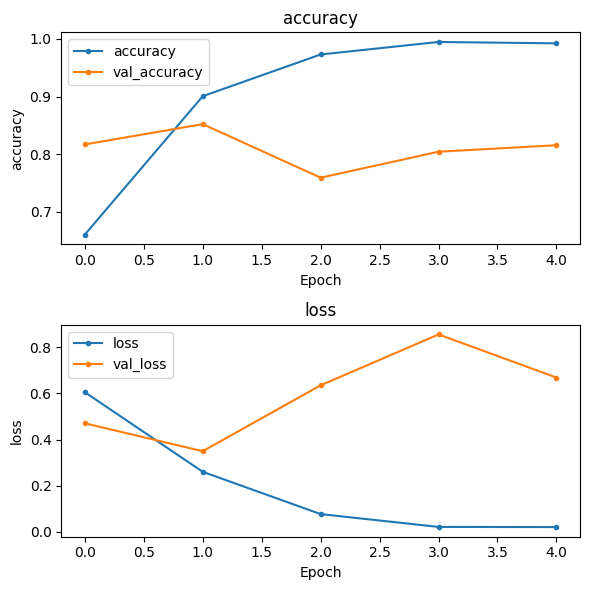


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       1.00      1.00      1.00      1482

    accuracy                           1.00      2485
   macro avg       1.00      1.00      1.00      2485
weighted avg       1.00      1.00      1.00      2485



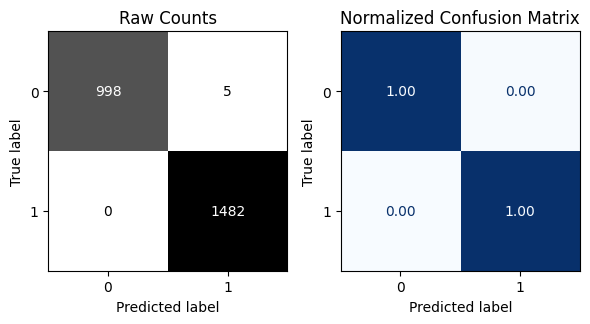


- Evaluating Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9978 - loss: 0.0078
{'accuracy': 0.9979879260063171, 'loss': 0.008391871117055416}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       166
           1       0.81      0.81      0.81       190

    accuracy                           0.79       356
   macro avg       0.79      0.79      0.79       356
weighted avg       0.80      0.79      0.79       356



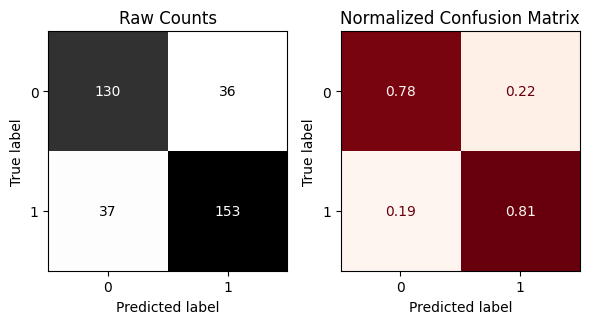


- Evaluating Test Data:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7890 - loss: 0.7653
{'accuracy': 0.7949438095092773, 'loss': 0.7555297613143921}


In [141]:
# Build the gru model and specify the vectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

gru_model = build_gru_model(text_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Obtain the results
results = evaluate_classification_network(
    gru_model, X_train=train_ds,
    X_test=test_ds, history=history
);

In [143]:
fpath_model = "Models/gru.keras"
#tf.keras.models.save_model(model, fpath_model)
gru_model.save(fpath_model)